### OCR Demo

In [1]:
import os
import cv2
import numpy as np
from glob import glob
import numpy.typing as npt
import matplotlib.pyplot as plt
from natsort import natsorted
from MonlamOCR.Inference import LineDetection, OCRInference, OCRPipeline
from MonlamOCR.Utils import read_line_model_config, read_ocr_model_config, get_rotation_angle_from_lines, rotate_from_angle, get_contours, build_line_data, sort_lines_by_threshold2, extract_line

kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


In [10]:
def show_image(image: np.array, cmap: str = "", axis="off", fig_x: int = 24, fix_y: int = 13) -> None:
    plt.figure(figsize=(fig_x, fix_y))
    plt.axis(axis)

    if cmap != "":
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)

def show_overlay(image: np.array, mask: np.array, alpha=0.4, axis="off", fig_x: int = 24, fix_y: int = 13):
    plt.figure(figsize=(fig_x, fix_y))
    plt.axis(axis)
    plt.imshow(image)
    plt.imshow(mask, alpha=alpha)


def get_line_images(image: npt.NDArray, line_mask: npt.NDArray, k_factor: float = 0.75) -> tuple[list[npt.NDArray, float]]:
    angle = get_rotation_angle_from_lines(line_mask)

    rot_mask = rotate_from_angle(line_mask, angle)
    rot_img = rotate_from_angle(image, angle)

    line_contours = get_contours(rot_mask)
    line_data = [build_line_data(x) for x in line_contours]
    line_data = [x for x in line_data if x.bbox.h > 10]
    sorted_lines, line_treshold = sort_lines_by_threshold2(rot_mask, line_data)
    sorted_line_images = [extract_line(x, rot_img, k_factor) for x in sorted_lines]

    return sorted_line_images

In [3]:
data_path = "Data/W30337"
output_dir = os.path.join(data_path, "Output")

img_ext = "tif"
image_paths = natsorted(glob(f"{data_path}/*.{img_ext}"))

print(f"Images: {len(image_paths)}")

Images: 704


(1500, 8100, 3)


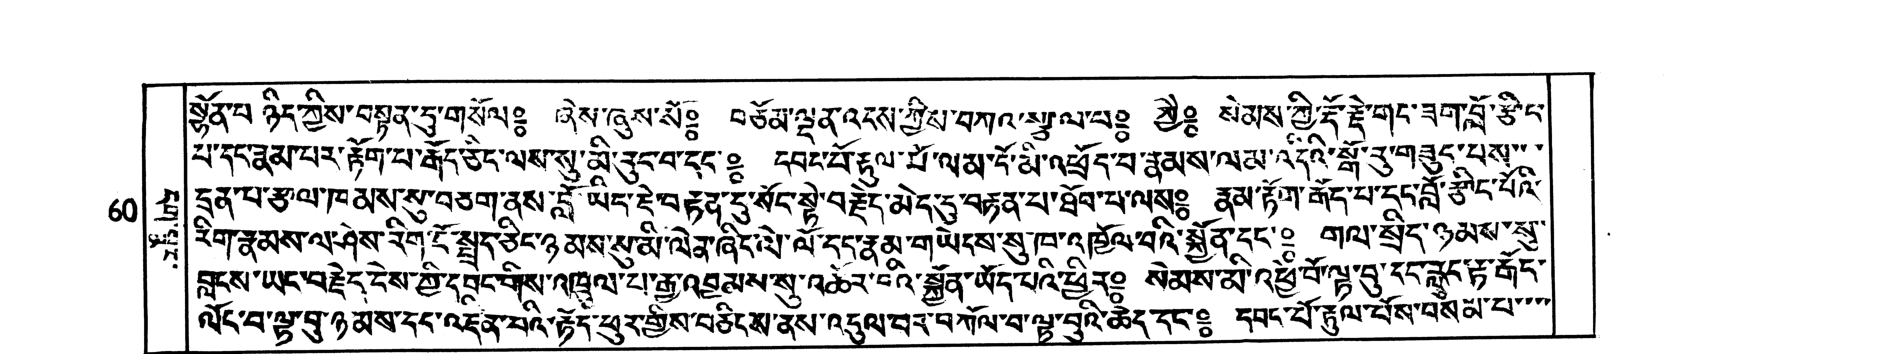

In [4]:
idx = 59
img = cv2.imread(image_paths[idx])
print(img.shape)
show_image(img)

In [5]:
# define models
line_model_file = "MonlamOCR/Models/Lines/config.json"
ocr_model_file = "MonlamOCR/Models/OCR/Woodblock/config.json"

#### 1) OCR via Pipeline

In [6]:
# run via pipeline
ocr_pipeline = OCRPipeline(ocr_model_file, line_model_file, output_dir)

In [7]:
text, line_data = ocr_pipeline.run_ocr(image_paths[idx])

for line in text:
    print(line)

ston pa nyid kyis bstan du gsol z+dza zhes zhus moha bcom ldan 'das kyisa bka' sal lan+da myeSh+Asems kyi rdo rje gang zag blo rtsing
pa dang rnam par rtog pa rgod cing las su mi rung ba dang +A dbang po rtal po lam de mi 'phrod pa rnams lam 'da'i sgo ru gzung pas
dran pa rtsal khams su bcag nas dlo yad rje brtan da song ste brjed med du brtan pa thob pa las+Arnam rtog rgod pa dang blo rtsing po'i
rig rnams la shes rig rdo sprad cing nyams su me len zhing ze mo dang rnam g.yengs su kha 'khyol ba'i sgron dang tragal srid nyams su
blangs yang brjed nges kyi dbang gis 'khrul pa rgya 'byams sa 'cher ba'i sgon yod pa'i phrir b sems ma 'phye bo lta bu dang rlang rta rgod
long ba lta bu nyams dang 'dzin pa'i rnyed phur gyis bcings nas 'dul bar bkol ba lta ba'i tshad dang dz+A dbang po rtul pos bsam pa


#### 2) Step by Step

(1500, 8100)


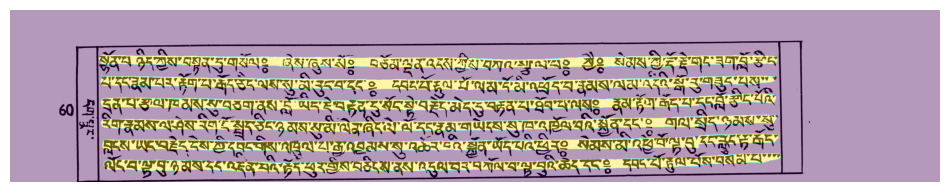

In [8]:
line_model_config = read_line_model_config(line_model_file)
line_infernce = LineDetection(line_model_config)

ocr_model_config = read_ocr_model_config(ocr_model_file)
ocr_infernce = OCRInference(ocr_model_config)

img = cv2.imread(image_paths[idx])
line_mask = line_infernce.predict(img, fix_height=True)

print(line_mask.shape)
show_overlay(img, line_mask, fig_x=12, fix_y=9)

ston pa nyid kyis bstan du gsol z+dza zhes zhus moha bcom ldan 'das kyisa bka' sal lan+da myeSh+Asems kyi rdo rje gang zag blo rtsing 
pa dang rnam par rtog pa rgod cing las su mi rung ba dang +A dbang po rtal po lam de mi 'phrod pa rnams lam 'da'i sgo ru gzung pas 
dran pa rtsal khams su bcag nas dlo yad rje brtan da song ste brjed med du brtan pa thob pa las+Arnam rtog rgod pa dang blo rtsing po'i 
rig rnams la shes rig rdo sprad cing nyams su me len zhing ze mo dang rnam g.yengs su kha 'khyol ba'i sgron dang tragal srid nyams su 
blangs yang brjed nges kyi dbang gis 'khrul pa rgya 'byams sa 'cher ba'i sgon yod pa'i phrir b sems ma 'phye bo lta bu dang rlang rta rgod 
long ba lta bu nyams dang 'dzin pa'i rnyed phur gyis bcings nas 'dul bar bkol ba lta ba'i tshad dang dz+A dbang po rtul pos bsam pa 


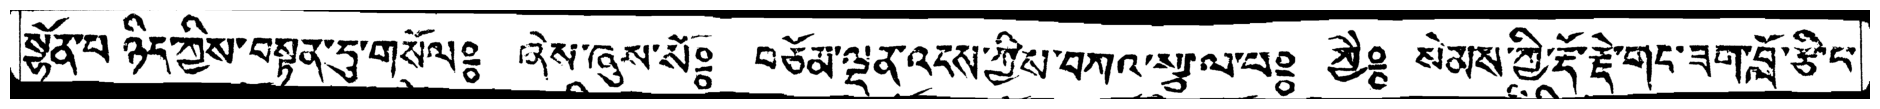

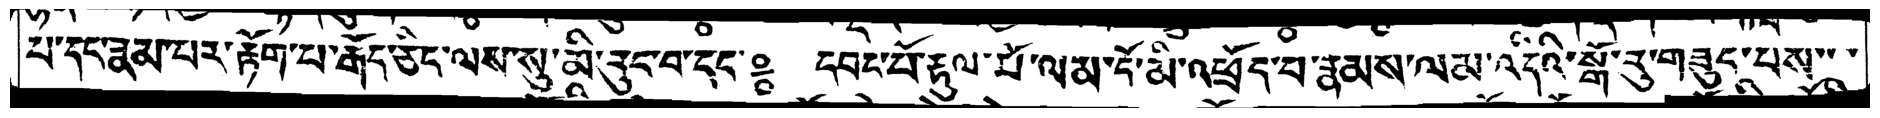

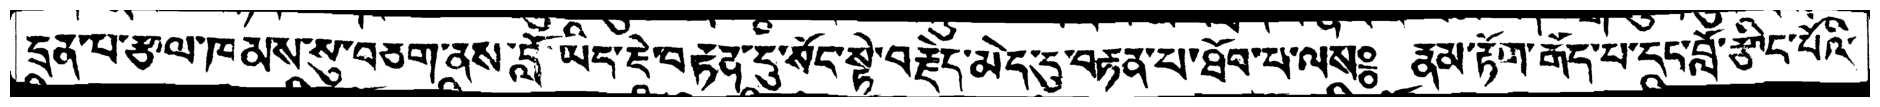

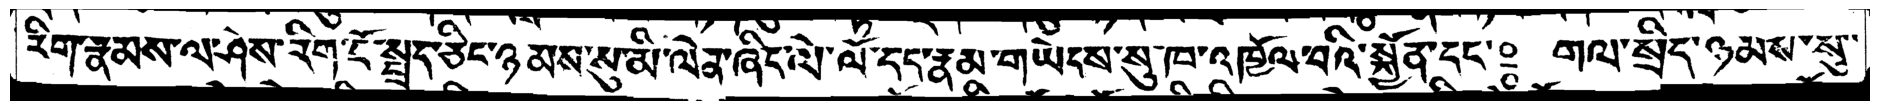

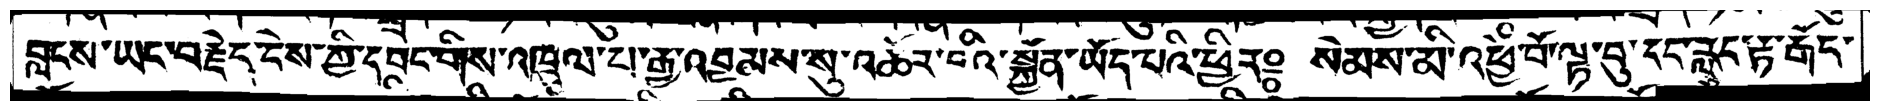

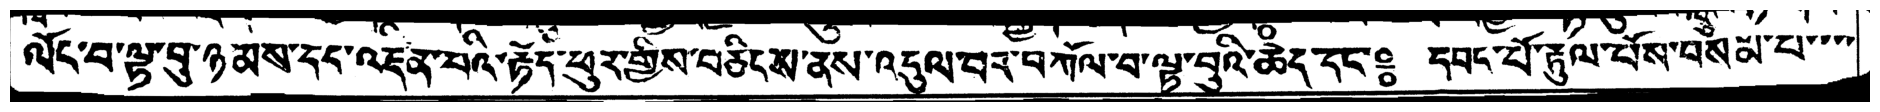

In [11]:
line_images = get_line_images(img, line_mask)

for line_img in line_images:
    text = ocr_infernce.run(line_img)
    print(text)
    show_image(line_img)